<a href="https://colab.research.google.com/github/mmcdermott/AUC_is_all_you_need/blob/main/AUROC_AUPRC_equivalencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netcal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import itertools
import numpy as np
import pandas as pd
import plotly.express as px
import warnings

from collections import defaultdict
from plotly.subplots import make_subplots
from scipy.stats import binom, spearmanr, pearsonr, NearConstantInputWarning, ConstantInputWarning
from sklearn.metrics import auc, average_precision_score, roc_auc_score, roc_curve
from tqdm.auto import tqdm
from typing import Callable

from sklearn.calibration import CalibratedClassifierCV,  _SigmoidCalibration, _sigmoid_calibration
from sklearn.isotonic import IsotonicRegression
from netcal.metrics import ECE

# Validating Theoretical Relationships Between AUROC and AUPRC
Claims:
1. $\mathrm{AUROC}_{\boldsymbol \theta} = 1 - \mathbb{E}_{p_+}[\mathrm{FPR}]$, and $\mathrm{AUPRC}_{\boldsymbol \theta} = 1 - P_{\mathsf y}(y = 0)\mathbb{E}_{p_+}\left[\frac{\mathrm{FPR}}{P_{\mathsf p}(p > p_+)}\right]$
2. That #1 implies that AUROC favors all local swaps from incorrect ordered neighbors to correctly ordered neighbors equally, but AUPRC favors them in inverse correlation with model hit rate
2. When there is a high prevalence of positive labels, then $\mathrm{AUPRC} \approx 1 + \frac{P_{\mathsf y}(y=0)}{P_{\mathsf y}(y=1)} \mathrm{AU(log)ROC}$

## Utility Functions

In [ ]:
def sample_at_AUROC(
    N: int, target_AUROC: float, pos_prev: float, seed: int = 1,
    normalize_score_to_prevalence = False,
    calibrate = True,
    calibration_method = 'platt'
) -> tuple[np.ndarray, np.ndarray]:
  """This function samples probabilities and binary labels at the given AUROC

  Args:
      N: The number of samples to return
      target_AUROC: The desired AUROC the resulting probabilities and labels
          should display.
      pos_prev: The prevalence of the positive label.
      seed: The random seed that should be used.
  """

  if N <= 0:
    raise ValueError(f"N must be a positive int; got {N}")
  if target_AUROC < 0 or target_AUROC > 1:
    raise ValueError(f"target_AUROC must be in [0, 1]; got {target_AUROC}")
  if pos_prev <= 0 or pos_prev >= 1:
    raise ValueError(f"pos_prev must be in (0, 1); got {pos_prev}")

  rng = np.random.default_rng(seed)

  N_true = int(round((pos_prev * N)))
  N_false = N - N_true

  if N_true == 0 or N_false == 0:
    raise ValueError(f"pos_prev is too extreme; got {N_true} and {N_false}")

  pos_scores = list(sorted(rng.uniform(low=0, high=1, size=N_true)))

  bounds = [0] + pos_scores
  neg_score_window_probs = []
  for n_pos_lt, lb in enumerate(bounds):
    # probability that a negative sample is > n_pos_lt is (1-AUC)**n_pos_lt
    neg_score_window_probs.append(binom.pmf(n_pos_lt, N_true, 1-target_AUROC))

  neg_scores = []
  for _ in range(N_false):
    window = rng.choice(len(bounds), p=neg_score_window_probs, size=1).item()
    window = int(window)
    lb = bounds[window]
    ub = (bounds + [1])[window+1]
    neg_scores.append(rng.uniform(low=lb, high=ub, size=1).item())

  scores = np.concatenate((pos_scores, neg_scores))
  Ys = np.array([True] * N_true + [False] * N_false)

  if normalize_score_to_prevalence:
    scores = scores / scores.mean() * pos_prev

  if calibrate:
    if calibration_method == 'isotonic':
        clf = IsotonicRegression().fit(scores, Ys)
        scores = clf.transform(scores)
    elif calibration_method == 'platt':
        clf = _SigmoidCalibration().fit(scores, Ys)
        scores = clf.predict(scores)

  return scores, Ys

## Theorem 1
$\mathrm{AUROC}_{\boldsymbol \theta} = 1 - \mathbb{E}_{p_+}[\mathrm{FPR}]$, and $\mathrm{AUPRC}_{\boldsymbol \theta} = 1 - P_{\mathsf y}(y = 0)\mathbb{E}_{p_+}\left[\frac{\mathrm{FPR}}{P_{\mathsf p}(p > p_+)}\right]$

In [ ]:
def expectation_based_AUROC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUROC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  sorted_idx = np.argsort(probs)
  labels = labels[sorted_idx]

  N_neg = (labels == 0).sum()
  pos_idx = np.argwhere(labels == 1)

  n_FPs = (labels == 0)[::-1].cumsum()[::-1]
  FPRs = n_FPs / N_neg

  exp = FPRs[pos_idx].mean()
  return 1 - exp

def expectation_based_AUPRC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUPRC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  sorted_idx = np.argsort(probs)
  labels = labels[sorted_idx]

  N = len(labels)
  N_neg = (labels == 0).sum()
  pos_idx = np.argwhere(labels == 1)

  n_FPs = (labels == 0)[::-1].cumsum()[::-1]
  FPRs = n_FPs / N_neg

  hit_rates = np.ones_like(probs)[::-1].cumsum()[::-1]/N

  weighted_FPRs = FPRs/hit_rates

  exp = weighted_FPRs[pos_idx].mean()
  return 1 - (N_neg/N)*exp

In [ ]:
N_seeds = 5
grid_size = 50
N_samples = 1000

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    out["AUROC/target"].append(AUROC)
    out["prev"].append(prev)
    out["seed"].append(seed)

    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    out["AUROC/sklearn"].append(roc_auc_score(Ys, probs))
    out["AUROC/theory"].append(expectation_based_AUROC(Ys, probs))
    out["AUPRC/sklearn"].append(average_precision_score(Ys, probs))
    out["AUPRC/theory"].append(expectation_based_AUPRC(Ys, probs))

out = pd.DataFrame(out)

pd.DataFrame({
    'AUROC/summ': (out['AUROC/sklearn']).describe(),
    'AUPRC/summ': (out['AUPRC/sklearn']).describe(),
    'AUROC/delta': (out['AUROC/sklearn'] - out['AUROC/theory']).describe(),
    'AUPRC/delta': (out['AUPRC/sklearn'] - out['AUPRC/theory']).describe(),
})

  0%|          | 0/2500 [00:00<?, ?it/s]

,AUROC/summ,AUPRC/summ,AUROC/delta,AUPRC/delta
count,12500.000000,12500.000000,1.250000e+04,1.250000e+04
mean,0.744869,0.844923,2.930989e-19,-3.002043e-18
std,0.141781,0.138246,8.067856e-17,7.310829e-17
min,0.448811,0.183873,-3.330669e-16,-3.330669e-16
25%,0.626494,0.768955,0.000000e+00,0.000000e+00
50%,0.745107,0.885114,0.000000e+00,0.000000e+00
75%,0.863411,0.955609,0.000000e+00,0.000000e+00
max,0.981735,0.999631,3.330669e-16,3.330669e-16


In [ ]:
out

,AUROC/target,prev,seed,AUROC/sklearn,AUROC/theory,AUPRC/sklearn,AUPRC/theory
0,0.019608,0.019608,0,0.980663,0.980663,0.899495,0.899495
1,0.019608,0.019608,1,0.981531,0.981531,0.910695,0.910695
2,0.019608,0.019608,2,0.979643,0.979643,0.899490,0.899490
3,0.019608,0.019608,3,0.978520,0.978520,0.887662,0.887662
4,0.019608,0.019608,4,0.981122,0.981122,0.903544,0.903544
...,...,...,...,...,...,...,...
12495,0.980392,0.980392,0,0.981633,0.981633,0.999628,0.999628
12496,0.980392,0.980392,1,0.979337,0.979337,0.999581,0.999581
12497,0.980392,0.980392,2,0.979745,0.979745,0.999590,0.999590
12498,0.980392,0.980392,3,0.981735,0.981735,0.999631,0.999631


### Lemma 1.1: AUROC improves with all mistakes equally, AUPRC favors higher scored predictions


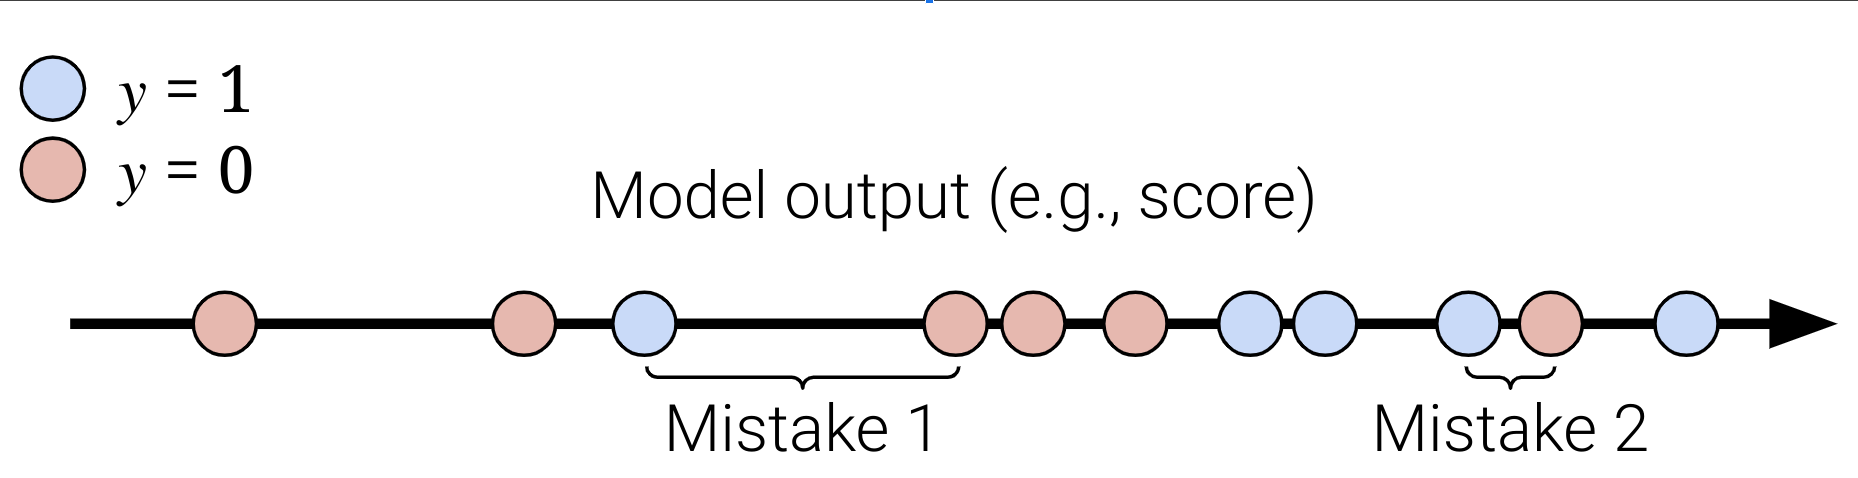



In [ ]:
N_seeds = 3
N_pairs = 20
grid_size = 25
N_samples = 100

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
summary_out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    sort_idx = np.argsort(probs)
    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pairs = []
    for i in range(N_samples - 1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pairs.append((i, i + 1))

    rng = np.random.default_rng(seed)
    rng.shuffle(pairs)
    samp_pairs = pairs[:N_pairs]
    if len(samp_pairs) <= 2:
      continue

    L = len(out["AUROC/orig"])

    for i, j in samp_pairs:
      out["AUROC/orig"].append(AUROC)
      out["AUPRC/orig"].append(average_precision_score(Ys, probs))
      out["prev"].append(prev)
      out["seed"].append(seed)
      out["pair_prob"].append(probs[i])
      out["pair_hit_rate"].append((N_samples - i)/N_samples)


      probs_if_fixed = probs.copy()
      pi = probs_if_fixed[i]
      pj = probs_if_fixed[j]
      probs_if_fixed[i] = pj
      probs_if_fixed[j] = pi

      out["AUROC/mistake_fixed"].append(roc_auc_score(Ys, probs_if_fixed))
      out["AUPRC/mistake_fixed"].append(average_precision_score(Ys, probs_if_fixed))

    summary_out["AUROC/orig"].append(AUROC)
    summary_out["AUPRC/orig"].append(average_precision_score(Ys, probs))
    summary_out["prev"].append(prev)
    summary_out["seed"].append(seed)

    aurocs = np.array(out["AUROC/mistake_fixed"][L:]).round(5)
    auprcs = np.array(out["AUPRC/mistake_fixed"][L:]).round(5)
    probs = np.array(out["pair_prob"][L:])
    hit_rates = np.array(out["pair_hit_rate"][L:])

    summary_out["AUROC/delta_fixed"].append(max(aurocs) - min(aurocs))
    summary_out["AUPRC/delta_fixed"].append(max(auprcs) - min(auprcs))

    with warnings.catch_warnings():
      warnings.simplefilter('ignore', NearConstantInputWarning)
      warnings.simplefilter('ignore', ConstantInputWarning)

      spearman_coeff, spearman_p = spearmanr(1/hit_rates, auprcs)
      summary_out["AUPRC_v_hit_rates/spearmanr/p"].append(spearman_p)
      summary_out["AUPRC_v_hit_rates/spearmanr/coeff"].append(spearman_coeff)

      pearson_coeff, pearson_p = pearsonr(1/hit_rates, auprcs)
      summary_out["AUPRC_v_hit_rates/pearsonr/p"].append(pearson_p)
      summary_out["AUPRC_v_hit_rates/pearsonr/coeff"].append(pearson_coeff)

      spearman_coeff, spearman_p = spearmanr(1/hit_rates, aurocs)
      summary_out["AUROC_v_hit_rates/spearmanr/p"].append(spearman_p)
      summary_out["AUROC_v_hit_rates/spearmanr/coeff"].append(spearman_coeff)

      pearson_coeff, pearson_p = pearsonr(1/hit_rates, aurocs)
      summary_out["AUROC_v_hit_rates/pearsonr/p"].append(pearson_p)
      summary_out["AUROC_v_hit_rates/pearsonr/coeff"].append(pearson_coeff)


out = pd.DataFrame(out)
summary_out = pd.DataFrame(summary_out)

summary_out[[c for c in summary_out.columns if c.startswith("AU")]].describe()

  0%|          | 0/625 [00:00<?, ?it/s]

,AUROC/orig,AUPRC/orig,AUROC/delta_fixed,AUPRC/delta_fixed,AUPRC_v_hit_rates/spearmanr/p,AUPRC_v_hit_rates/spearmanr/coeff,AUPRC_v_hit_rates/pearsonr/p,AUPRC_v_hit_rates/pearsonr/coeff,AUROC_v_hit_rates/spearmanr/p,AUROC_v_hit_rates/spearmanr/coeff,AUROC_v_hit_rates/pearsonr/p,AUROC_v_hit_rates/pearsonr/coeff
count,1848.000000,1848.000000,1.848000e+03,1848.000000,1.848000e+03,1848.000000,1.848000e+03,1848.000000,2.000000,2.000000,2.000000,2.000000
mean,0.501145,0.806950,1.082251e-08,0.003309,2.000807e-03,0.993584,4.647465e-03,0.990858,0.483602,-0.516398,0.586395,-0.413605
std,0.274423,0.185675,3.288868e-07,0.010811,1.820165e-02,0.015974,2.095153e-02,0.011615,0.365148,0.365148,0.484135,0.484135
min,0.038462,0.066452,0.000000e+00,0.000010,0.000000e+00,0.774597,1.411283e-18,0.848728,0.225403,-0.774597,0.244059,-0.755941
25%,0.269231,0.726125,0.000000e+00,0.000170,0.000000e+00,0.994030,4.903118e-12,0.988388,0.354503,-0.645497,0.415227,-0.584773
50%,0.500000,0.864344,0.000000e+00,0.000490,1.045313e-13,0.997725,6.935150e-09,0.993490,0.483602,-0.516398,0.586395,-0.413605
75%,0.730769,0.946895,0.000000e+00,0.001950,3.698093e-10,1.000000,9.400612e-06,0.996542,0.612702,-0.387298,0.757562,-0.242438
max,0.961538,0.998621,1.000000e-05,0.124870,3.333333e-01,1.000000,3.409114e-01,0.999980,0.741801,-0.258199,0.928730,-0.071270


### Lemma 1.2: Optimizing for AUPRC excacerbates disparities between groups with different prevalences

Suppose we have two subpopulations, $X_1$ and $X_2$, such that the prevalence of the positive label differs between $X_1$ and $X_2$.

In [ ]:
def fix_mistake_by_AUPRC(Ys: np.ndarray, probs: np.ndarray, *args, **kwargs) -> np.ndarray:
    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)

    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pair = None
    for i in range(len(Ys)-2, 0, -1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pair = (i, i+1)
      break

    if pair is None: return probs[unsort_idx]

    i, j = pair
    probs_if_fixed = probs.copy()
    pi = probs_if_fixed[i]
    pj = probs_if_fixed[j]
    probs_if_fixed[i] = pj
    probs_if_fixed[j] = pi

    return probs_if_fixed[unsort_idx]

def fix_mistake_by_AUROC(Ys: np.ndarray, probs: np.ndarray, *args, **kwargs) -> np.ndarray:
    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)

    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pairs = []
    for i in range(len(Ys)-2, 0, -1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pairs.append((i, i+1))

    if not pairs: return probs[unsort_idx]

    pair = pairs[np.random.choice(len(pairs))]

    i, j = pair
    probs_if_fixed = probs.copy()
    pi = probs_if_fixed[i]
    pj = probs_if_fixed[j]
    probs_if_fixed[i] = pj
    probs_if_fixed[j] = pi

    return probs_if_fixed[unsort_idx]

def sample_perturbation(lower, upper, N, n_trials, rng):
    if np.isscalar(lower) and np.isscalar(upper): # bounds are simple scalars, just generate the matrix
        return rng.uniform(lower, upper, size = (N, n_trials))
    # convert both bounds to arrays
    if np.isscalar(lower):
        lower = np.ones((N, )) * lower
    if np.isscalar(upper):
        upper = np.ones((N, )) * upper

    return np.vstack([rng.uniform(lower[i], upper[i], size = (1, n_trials)) for i in range(N)])

def random_perturb(Ys: np.ndarray, probs: np.ndarray, step: int, optimize: str = 'AUROC',
                   compute_magnitude_method: str = 'step',
                   magnitude_inc: float = 0.001, magnitude_override: float = 0.01,
                   n_trials: int = 100, directed: bool = False, seed: int = 0) -> np.ndarray:
    '''
    To specify the max magnitude of the perturbation:
        if compute_magnitude_method == 'step', then it is step * magnitude_inc
        if compute_magnitude_method == 'magnitude', it is magnitude_override
        if compute_magnitude_method == 'per_sample', the magnitude for each sample is magnitude_override * min(s, 1-s)
    '''
    rng = np.random.default_rng(seed)
    if compute_magnitude_method == 'step':
        magnitude = magnitude_inc * step
    elif compute_magnitude_method == 'magnitude':
        magnitude = magnitude_override
    elif compute_magnitude_method == 'per_sample':
        magnitude = magnitude_override * np.minimum(probs, 1-probs)
    else:
        raise NotImplementedError(compute_magnitude_method)

    if not directed:
        perturb_mat = sample_perturbation(-magnitude, magnitude, len(Ys), n_trials, rng)
    else:
        perturb_mat = np.zeros((len(Ys), n_trials))
        perturb_mat[Ys == 0, :] = sample_perturbation(-magnitude, 0, len(Ys), n_trials, rng)[Ys == 0, :]
        perturb_mat[Ys == 1, :] = sample_perturbation(0, magnitude, len(Ys), n_trials, rng)[Ys == 1, :]

    if probs.ndim == 1:
        probs = np.expand_dims(probs, -1)

    new_probs = np.clip(probs + perturb_mat, 0, 1)
    if optimize == 'AUROC':
        func = roc_auc_score
    elif optimize == 'AUPRC':
        func = average_precision_score
    else:
        raise NotImplementedError(optimize)
    mets = np.apply_along_axis(lambda a: func(Ys, a), axis = 0, arr = new_probs)

    return new_probs[:, mets.argmax()]

In [ ]:
def sample_rank_permutation(
    max_per_sample_rank_delta: int, N: int, n_trials: int, rng
) -> np.ndarray:
    """Generates a permutation matrix with no elements above or below a diag.
    """

    permutation_matrices_scores = rng.uniform(low=0, high=1, size=(n_trials, N, N))
    permutation_matrices_scores = np.triu(np.tril(
        permutation_matrices_scores, k=max_per_sample_rank_delta
    ), k=-max_per_sample_rank_delta)
    # permutation matrices now has zeros above and below the appropriate
    # diagonals.

    permutation_matrices = np.zeros_like(permutation_matrices_scores)

    options_per_row = np.sum(
      permutation_matrices_scores != 0, axis=1, keepdims=True
    )
    options_per_col = np.sum(
      permutation_matrices_scores != 0, axis=2, keepdims=True
    )

    for i in range(N):
      # If we have no other options:
      is_omitted = (permutation_matrices_scores == 0)

      idx_must_choose = (
          ((options_per_row == 1) | (options_per_col == 1)) &
          ~is_omitted
      )

      any_must_choose = idx_must_choose.max(axis=(1, 2), keepdims=True)

      idx_is_max = (
          permutation_matrices_scores ==
          permutation_matrices_scores.max(axis=(1, 2), keepdims=True)
      )

      selection_idx = (
          idx_must_choose |
          (idx_is_max & ~any_must_choose & ~is_omitted)
      )

      n_selections = selection_idx.sum(axis=(1, 2))
      # if n_selections.max() > 1:
      #   max_must_choose = idx_must_choose.sum(axis=(1, 2)).max()
      #   max_idx_is_max = idx_is_max.sum(axis=(1, 2)).max()
      #   print(permutation_matrices_scores)
      #   print(permutation_matrices)
      #   print(idx_must_choose)
      #   print(options_per_row)
      #   print(options_per_col)
      #   print(is_omitted)
      #   raise ValueError(
      #       f"Got {n_selections.max()} > 1 on {i}! "
      #       f"{max_must_choose} must be chosen and "
      #       f"{max_idx_is_max} are maximal"
      #   )
      # if n_selections.min() <= 0:
      #   print(permutation_matrices_scores)
      #   print(permutation_matrices)
      #   print(idx_must_choose)
      #   print(options_per_row)
      #   print(options_per_col)
      #   print(is_omitted)
      #   raise ValueError(
      #       f"Got {n_selections.min()} <= 0 on {i}!"
      #   )

      selection_in_row = selection_idx.max(axis=1, keepdims=True)
      selection_in_col = selection_idx.max(axis=2, keepdims=True)

      permutation_matrices_scores = np.where(
          (selection_in_row == 1) | (selection_in_col == 1), 0,
          permutation_matrices_scores
      )

      permutation_matrices = np.where(
          selection_idx == 1, 1, permutation_matrices
      )

      options_per_row = np.sum(
        permutation_matrices_scores != 0, axis=1, keepdims=True
      )
      options_per_col = np.sum(
        permutation_matrices_scores != 0, axis=2, keepdims=True
      )
      # options_per_row = np.where(
      #     selection_in_row == 1, options_per_row - 1, options_per_row
      # )
      # options_per_col = np.where(
      #     selection_in_col == 1, options_per_col - 1, options_per_col
      # )
      # options_per_row[selection_in_row == 1] -= 1
      # options_per_col[selection_in_col == 1] -= 1


    return permutation_matrices


In [ ]:
def random_rank_perturb(
    Ys: np.ndarray, probs: np.ndarray, optimize: str = 'AUROC',
    max_sample_rank_delta: int = 3, n_trials: int = 100,
    seed: int = 0, **kwargs
) -> np.ndarray:
    ''' Perturbs the scores by randomly re-ordering subject to constraints.
    '''

    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)


    probs = probs[sort_idx]
    Ys = Ys[sort_idx]
    rng = np.random.default_rng(seed)

    permutation_matrices = sample_rank_permutation(
        max_sample_rank_delta, len(Ys), n_trials, rng
    )
    # permutation_matrices is of shape (n_trials, N, N)

    # probs is of shape (N,)
    permuted_probs = np.expand_dims(
        np.tile(np.expand_dims(probs, 0), (n_trials, 1)), -1
    )
    # permuted_probs is of shape (n_trials, N, 1)

    # actually do the permutations
    permuted_probs = permutation_matrices @ permuted_probs

    if optimize == 'AUROC':
        func = roc_auc_score
    elif optimize == 'AUPRC':
        func = average_precision_score
    else:
        raise NotImplementedError(f"optimize score {optimize} not supported")

    mets = np.apply_along_axis(
        lambda a: func(Ys, a), axis = 1, arr = permuted_probs
    )

    return permuted_probs[mets.argmax(), :].squeeze(-1)[unsort_idx]

In [ ]:
def check_optimization_drift(
    optimizer_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
    subgroup_1_kwargs: dict[str, float],
    subgroup_2_kwargs: dict[str, float],
    N_steps: int = 50,
    N_seeds: int = 10,
    optimizer_fn_kwargs: dict[str, float] = {},
    override_probs_each_step: bool = True
) -> dict[str, list[float]]:
  data_frames = []
  for seed in tqdm(list(range(N_seeds)), desc="Seeds"):
    data_frames.append(check_optimization_drift_once(
        optimizer_fn, subgroup_1_kwargs, subgroup_2_kwargs, N_steps, seed,
        optimizer_fn_kwargs, override_probs_each_step
    ))

  out_frame = {
      "step": data_frames[0].step.values,
      "Variable": data_frames[0].Variable.values,
  }

  for col in data_frames[0].columns:
    if col in out_frame: continue

    f = pd.DataFrame({i: df[col] for i, df in enumerate(data_frames)})
    out_frame[f"{col}/mean"] = f.mean(axis=1).values
    out_frame[f"{col}/std"] = f.std(axis=1).values

  return pd.DataFrame(out_frame)

def check_optimization_drift_once(
    optimizer_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
    subgroup_1_kwargs: dict[str, float],
    subgroup_2_kwargs: dict[str, float],
    N_steps: int = 50,
    seed: int = 1,
    optimizer_fn_kwargs: dict[str, float] = {},
    override_probs_each_step: bool = True
) -> dict[str, list[float]]:
    np.random.seed(seed)

    probs_1, labels_1 = sample_at_AUROC(**subgroup_1_kwargs, seed=seed)
    probs_2, labels_2 = sample_at_AUROC(**subgroup_2_kwargs, seed=seed)

    probs = np.concatenate((probs_1, probs_2))
    probs_back = np.copy(probs)
    labels = np.concatenate((labels_1, labels_2))
    subgroup_idx = np.concatenate(
        (np.zeros_like(probs_1), np.ones_like(probs_2))
    )

    results = defaultdict(list)
    for step in tqdm(list(range(N_steps)), desc="Steps", leave=False):
      results["step"].append(step)
      results["AUROC/overall"].append(roc_auc_score(labels, probs))
      results["AUROC/subpop_1"].append(roc_auc_score(
        labels[subgroup_idx == 0], probs[subgroup_idx == 0]
      ))
      results["AUROC/subpop_2"].append(roc_auc_score(
        labels[subgroup_idx == 1], probs[subgroup_idx == 1]
      ))
      results["AUPRC/overall"].append(average_precision_score(labels, probs))
      results["AUPRC/subpop_1"].append(average_precision_score(
        labels[subgroup_idx == 0], probs[subgroup_idx == 0]
      ))
      results["AUPRC/subpop_2"].append(average_precision_score(
        labels[subgroup_idx == 1], probs[subgroup_idx == 1]
      ))

      results["ECE/overall"].append(ECE().measure(probs, labels))
      results["ECE/subpop_1"].append(ECE().measure(
        probs[subgroup_idx == 0], labels[subgroup_idx == 0]
      ))
      results["ECE/subpop_2"].append(ECE().measure(
        probs[subgroup_idx == 1], labels[subgroup_idx == 1]
      ))

      results["AUROC/subgroup_differentiation"].append(
        roc_auc_score(subgroup_idx, probs)
      )
      results["AUPRC/subgroup_differentiation"].append(
        average_precision_score(subgroup_idx, probs)
      )

      results["ECE/subgroup_differentiation"].append(
        ECE().measure(probs, subgroup_idx)
      )

      if override_probs_each_step:
        probs = optimizer_fn(labels, probs, step = step, seed = seed, **optimizer_fn_kwargs)
      else:
        probs = optimizer_fn(labels, probs_back, step = step, seed = seed, **optimizer_fn_kwargs)

    out = pd.DataFrame(results)

    out_long = pd.DataFrame(out).melt(
        id_vars=['step'],
        value_vars=[c for c in results.keys() if c.startswith("AU") or c.startswith('ECE')],
        var_name='Variable',
        value_name='Value',
    )

    return out_long

def AUROC_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("AUROC")]

def AUPRC_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("AUPRC")]

def ECE_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("ECE")]

def overall_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "overall" in x)]

def subpops_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subpop_" in x)]

def differentiation_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subgroup_differentiation" in x)]

def plot_optimization_results(out_long: pd.DataFrame, title: str, x_var: str = 'step'):
  # Create a subplot figure
  fig = make_subplots(
      rows=3, cols=3, subplot_titles=(
          "AUROC/overall", "AUROC/by_subpop", "AUROC/separate",
          "AUPRC/overall", "AUPRC/by_subpop", "AUPRC/separate",
          "ECE/overall", "ECE/by_subpop", "ECE/separate")
  )

  plt_kwargs = dict(
      x=x_var, y="Value/mean", error_y="Value/std", color="Variable"
  )

  AUROC_overall = px.line(
      AUROC_only(overall_only(out_long)), **plt_kwargs
  )
  AUROC_by_subpop = px.line(
      AUROC_only(subpops_only(out_long)), **plt_kwargs
  )
  AUROC_separate = px.line(
      AUROC_only(differentiation_only(out_long)), **plt_kwargs
  )

  AUPRC_overall = px.line(
      AUPRC_only(overall_only(out_long)), **plt_kwargs
  )
  AUPRC_by_subpop = px.line(
      AUPRC_only(subpops_only(out_long)), **plt_kwargs
  )
  AUPRC_separate = px.line(
      AUPRC_only(differentiation_only(out_long)), **plt_kwargs
  )

  ECE_overall = px.line(
      ECE_only(overall_only(out_long)), **plt_kwargs
  )
  ECE_by_subpop = px.line(
      ECE_only(subpops_only(out_long)), **plt_kwargs
  )
  ECE_separate = px.line(
      ECE_only(differentiation_only(out_long)), **plt_kwargs
  )

  for trace in AUROC_overall['data']:
      fig.add_trace(trace, row=1, col=1)
  for trace in AUROC_by_subpop['data']:
      fig.add_trace(trace, row=1, col=2)
  for trace in AUROC_separate['data']:
      fig.add_trace(trace, row=1, col=3)

  for trace in AUPRC_overall['data']:
      fig.add_trace(trace, row=2, col=1)
  for trace in AUPRC_by_subpop['data']:
      fig.add_trace(trace, row=2, col=2)
  for trace in AUPRC_separate['data']:
      fig.add_trace(trace, row=2, col=3)

  for trace in ECE_overall['data']:
      fig.add_trace(trace, row=3, col=1)
  for trace in ECE_by_subpop['data']:
      fig.add_trace(trace, row=3, col=2)
  for trace in ECE_separate['data']:
      fig.add_trace(trace, row=3, col=3)
  # Update layout if necessary
  fig.update_layout(title_text=title)

  return fig

Fix Mistakes

In [ ]:
figs = []
for target_auroc in [0.85, 0.65]:
    for met_name, met_func in [('AUROC', fix_mistake_by_AUROC), ('AUPRC', fix_mistake_by_AUPRC)]:
        out_long = check_optimization_drift(
            met_func,
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.05},
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.01},
            N_seeds = 10,
        )
        fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}")
        figs.append(fig)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

Random perturbations: single step

In [ ]:
magnitude_inc = 0.002
figs = []
for directed in [False]:
    for target_auroc in [0.85]:
        for met_name in ['AUROC', 'AUPRC']:
            out_long = check_optimization_drift(
                random_perturb,
                {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.05},
                {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.01},
                N_seeds = 10,
                optimizer_fn_kwargs={'optimize': met_name, 'directed': directed, 'magnitude_inc': magnitude_inc, 'compute_magnitude_method': 'step'},
                override_probs_each_step = False
            )
            out_long['Max Magnitude'] = out_long['step'] * magnitude_inc
            fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}: {'Random Perturbation' if not directed else 'Directed Perturbation'}", x_var = 'Max Magnitude')
            figs.append(fig)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

Random perturbations: successive optimization

In [ ]:
figs = []
magnitude_override = 0.2
for directed in [False]:
    for target_auroc in [0.85]:
        for met_name in ['AUROC', 'AUPRC']:
            out_long = check_optimization_drift(
                random_perturb,
                {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.05},
                {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.01},
                N_seeds = 10,
                optimizer_fn_kwargs={'optimize': met_name, 'directed': directed, 'magnitude_override': magnitude_override, 'compute_magnitude_method': 'per_sample'},
                override_probs_each_step = True
            )
            out_long['Max Magnitude'] = out_long['step'] * magnitude_inc
            fig = plot_optimization_results(out_long, title=f"Successively Optimize by {met_name}: {'Random Perturbation' if not directed else 'Directed Perturbation'}", x_var = 'step')
            figs.append(fig)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

Randomly permute

In [ ]:
figs = []
for target_auroc in [0.85]:
    for met_name in ['AUROC', 'AUPRC']:
        out_long = check_optimization_drift(
            random_rank_perturb,
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.05},
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.01},
            N_seeds = 15,
            optimizer_fn_kwargs={'optimize': met_name, 'max_sample_rank_delta': 3, 'n_trials': 20},
            override_probs_each_step = True,
            N_steps=30
        )
        fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}: 'Random Permutation'", x_var = 'step')
        figs.append(fig)

Seeds:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Seeds:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

In [ ]:
figs = []
for target_auroc in [0.85]:
    for met_name in ['AUROC', 'AUPRC']:
        out_long = check_optimization_drift(
            random_rank_perturb,
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.05},
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.01},
            N_seeds = 6,
            optimizer_fn_kwargs={'optimize': met_name, 'max_sample_rank_delta': 3, 'n_trials': 25},
            override_probs_each_step = True,
            N_steps=15
        )
        fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}: 'Random Permutation'", x_var = 'step')
        figs.append(fig)

Seeds:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Seeds:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

In [ ]:
figs = []
for target_auroc in [0.85]:
    for met_name in ['AUROC', 'AUPRC']:
        out_long = check_optimization_drift(
            random_rank_perturb,
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.05},
            {"N": 100, "target_AUROC": target_auroc, "pos_prev": 0.01},
            N_seeds = 6,
            optimizer_fn_kwargs={'optimize': met_name, 'max_sample_rank_delta': 3},
            override_probs_each_step = True,
            N_steps=15
        )
        fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}: 'Random Permutation'", x_var = 'step')
        figs.append(fig)

Seeds:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Seeds:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

In [ ]:
figs = []
for target_auroc in [0.85]:
    for met_name in ['AUROC', 'AUPRC']:
        out_long = check_optimization_drift(
            random_rank_perturb,
            {"N": 50, "target_AUROC": target_auroc, "pos_prev": 0.25},
            {"N": 50, "target_AUROC": target_auroc, "pos_prev": 0.05},
            N_seeds = 3,
            optimizer_fn_kwargs={'optimize': met_name, 'max_sample_rank_delta': 2, 'n_trials': 500},
            override_probs_each_step = True,
            N_steps=10
        )
        fig = plot_optimization_results(out_long, title=f"Optimize by {met_name}: 'Random Permutation'", x_var = 'step')
        figs.append(fig)

Seeds:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Seeds:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for fig in figs:
    fig.show()

## Theorem 2
When there is a high prevalence of positive labels, then $\mathrm{AUPRC} \approx 1 + \frac{P_{\mathsf y}(y=0)}{P_{\mathsf y}(y=1)} \mathrm{AU(log)ROC}$

In [ ]:
def AULROC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUROC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  fpr, tpr, _ = roc_curve(labels, probs)
  fpr = fpr[1:]
  tpr = tpr[1:]

  with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    log_tpr = np.log(tpr)

    return auc(fpr, log_tpr)

In [ ]:
N_seeds = 5
grid_size = 50
N_samples = 1000

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    out["AUROC"].append(AUROC)
    out["prev"].append(prev)
    out["seed"].append(seed)

    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    out["AUPRC"].append(average_precision_score(Ys, probs))
    aulroc = AULROC(Ys, probs)
    out["AU(log)ROC"].append(aulroc)
    out["approx_AUPRC"].append(1 + ((1-prev)/prev) * aulroc)

out = pd.DataFrame(out)
out["Approximation Error"] = out["AUPRC"] - out["approx_AUPRC"]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
agg = out.groupby(["prev", "AUROC"])["Approximation Error"].agg(["mean", "std"])
agg = agg.reset_index()
px.line(agg, x="prev", y="mean", error_y="std", color="AUROC", log_y=True)

## Debugging the sample_at_AUROC function

In [ ]:
# Testing the function with a simple case
N = 1000
target_AUROC = 0.75
pos_prev = 0.3
scores, labels = sample_at_AUROC(N, target_AUROC, pos_prev)

# Calculating the actual AUROC of the generated scores
actual_AUROC = roc_auc_score(labels, scores)
actual_AUROC

0.7499857142857143

### Testing the AUROC and AUPRC calculation functions

In [ ]:
# Testing the AUROC and AUPRC calculation functions
theoretical_AUROC = expectation_based_AUROC(labels, scores)
theoretical_AUPRC = expectation_based_AUPRC(labels, scores)

theoretical_AUROC, theoretical_AUPRC

(0.7499857142857143, 0.8035350873694626)

## Fixing Expectation based AUROC

In [ ]:
def corrected_expectation_based_AUROC(labels, probs):
    sorted_idx = np.argsort(probs)[::-1]  # Sort probabilities in descending order
    labels = labels[sorted_idx]

    N_neg = np.sum(labels == 0)
    N_pos = np.sum(labels == 1)

    # Calculate the number of true positives and false positives at each threshold
    tps = np.cumsum(labels == 1)
    fps = np.cumsum(labels == 0)

    # Calculate the false positive rate at each threshold
    fpr = fps / N_neg if N_neg else np.zeros_like(fps)

    # Calculate the expectation of FPR over all positive instances
    expected_fpr = np.sum(fpr * (labels == 1)) / N_pos if N_pos else 0

    return 1 - expected_fpr

# Re-testing the AUROC calculation function
corrected_theoretical_AUROC = corrected_expectation_based_AUROC(labels, scores)
corrected_theoretical_AUROC


0.7499857142857143

In [ ]:
def corrected_expectation_based_AUPRC(labels, probs):
    sorted_idx = np.argsort(probs)[::-1]  # Sort probabilities in descending order
    labels = labels[sorted_idx]

    N = len(labels)
    N_neg = np.sum(labels == 0)
    N_pos = np.sum(labels == 1)

    # Calculate the number of true positives, false positives, and positives at each threshold
    tps = np.cumsum(labels == 1)
    fps = np.cumsum(labels == 0)
    pos_above_threshold = N - np.arange(N)

    # Calculate the precision and recall at each threshold
    precision = tps / pos_above_threshold if N_pos else np.zeros_like(tps)
    recall = tps / N_pos if N_pos else np.zeros_like(tps)

    # Calculate the weighted false positive rate
    weighted_fpr = (fps / N_neg) / recall if N_neg and N_pos else np.zeros_like(fps)

    # Calculate the expectation of weighted FPR over all positive instances
    expected_weighted_fpr = np.sum(weighted_fpr * (labels == 1)) / N_pos if N_pos else 0

    return 1 - (N_neg / N) * expected_weighted_fpr

# Re-testing the AUPRC calculation function
corrected_theoretical_AUPRC = corrected_expectation_based_AUPRC(labels, scores)
corrected_theoretical_AUPRC

0.7986455319947671

In [ ]:
debug_scores, debug_labels = debug_sample_at_AUROC(N=1000, target_AUROC=0.85, pos_prev=0.1, seed=42)


NameError: ignored

In [ ]:
debug_scores

## Audit the fix_mistake_by_AUPRC function

In [ ]:
def audit_fix_mistake_by_AUPRC(Ys, probs):
    sort_idx = np.argsort(probs)
    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    for i in range(len(Ys) - 1, 0, -1):
        if Ys[i] == 1 and Ys[i - 1] == 0:
            # Found a pair to swap
            return True  # A pair is found, function works as expected

    return False  # No pair is found, function might not work as expected

# Testing the audit_fix_mistake_by_AUPRC function
has_pairs_to_swap = audit_fix_mistake_by_AUPRC(debug_labels, debug_scores)
print(f"Does the function find pairs to swap? {has_pairs_to_swap}")

# Here we mock the optimizer function since we cannot execute complex functions
# like `fix_mistake_by_AUPRC` without full context.
def mock_optimizer_fn(Ys, probs):
    # This is a mock function that would contain the logic of fix_mistake_by_AUPRC
    return probs

# Test the Optimization Loop
def test_optimization_loop(N_steps, optimizer_fn, scores, labels):
    for step in range(N_steps):
        # Apply the optimization function
        new_probs = optimizer_fn(labels, scores)

        # Calculate and log the metrics after each step
        auc = roc_auc_score(labels, new_probs)
        auprc = average_precision_score(labels, new_probs)

        print(f"Step {step}: AUROC = {auc}, AUPRC = {auprc}")

# Testing the optimization loop with a mock optimizer
test_optimization_loop(N_steps=50, optimizer_fn=mock_optimizer_fn, scores=debug_scores, labels=debug_labels)